#1-1

MNIST 데이터셋을 사용하여 간단한 GAN을 구현한 코드입니다.

코드를 실행시키고, 주석을 달아주세요.

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image


/home/vision/anaconda3/envs/orbit/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/vision/anaconda3/envs/orbit/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/home/vision/anaconda3/envs/orbit/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
num_epochs = 100
batch_size = 100
learning_rate = 0.0002
img_size = 28 * 28
noise_size = 100
hidden_size1 = 256
hidden_size2 = 512
hidden_size3 = 1024
dir_name = "GAN_results"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if not os.path.exists(dir_name):
    os.makedirs(dir_name)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

MNIST_dataset = datasets.MNIST(root='../../data/',
                               train=True,
                               transform=transform,
                               download=True)

data_loader = torch.utils.data.DataLoader(dataset=MNIST_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

In [3]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(img_size, hidden_size3),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_size3, hidden_size2),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_size2, hidden_size1),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_size1, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_size, hidden_size1),
            nn.ReLU(),
            nn.Linear(hidden_size1, hidden_size2),
            nn.ReLU(),
            nn.Linear(hidden_size2, hidden_size3),
            nn.ReLU(),
            nn.Linear(hidden_size3, img_size),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

discriminator = Discriminator().to(device)
generator = Generator().to(device)

criterion = nn.BCELoss()
d_optimizer = optim.Adam(discriminator.parameters(), lr=learning_rate)
g_optimizer = optim.Adam(generator.parameters(), lr=learning_rate)


In [4]:
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        real_images = images.reshape(batch_size, -1).to(device)

        g_optimizer.zero_grad()

        z = torch.randn(batch_size, noise_size).to(device)
        fake_images = generator(z)

        g_loss = criterion(discriminator(fake_images), real_labels)
        g_loss.backward()
        g_optimizer.step()

        d_optimizer.zero_grad()

        z = torch.randn(batch_size, noise_size).to(device)
        fake_images = generator(z)

        real_loss = criterion(discriminator(real_images), real_labels)
        fake_loss = criterion(discriminator(fake_images.detach()), fake_labels)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        d_optimizer.step()

        if (i + 1) % 150 == 0:
            print(f"Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(data_loader)}], "
                  f"D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")

    save_image(fake_images.view(batch_size, 1, 28, 28),
               os.path.join(dir_name, f'GAN_fake_image_{epoch + 1}.png'))

    d_performance = discriminator(real_images).mean().item()
    g_performance = discriminator(fake_images).mean().item()
    print(f"---------Epoch [{epoch + 1}/{num_epochs}] : D Performance: {d_performance:.2f}, G Performance: {g_performance:.2f}")

Epoch [1/100], Step [150/600], D Loss: 0.0334, G Loss: 3.2240
Epoch [1/100], Step [300/600], D Loss: 0.0593, G Loss: 11.4439
Epoch [1/100], Step [450/600], D Loss: 0.0009, G Loss: 8.1975
Epoch [1/100], Step [600/600], D Loss: 0.1662, G Loss: 6.8918
---------Epoch [1/100] : D Performance: 0.81, G Performance: 0.00
Epoch [2/100], Step [150/600], D Loss: 0.0099, G Loss: 8.6165
Epoch [2/100], Step [300/600], D Loss: 0.0016, G Loss: 6.1197
Epoch [2/100], Step [450/600], D Loss: 0.0009, G Loss: 7.3407
Epoch [2/100], Step [600/600], D Loss: 0.0128, G Loss: 6.5019
---------Epoch [2/100] : D Performance: 0.99, G Performance: 0.00
Epoch [3/100], Step [150/600], D Loss: 0.0172, G Loss: 10.2504
Epoch [3/100], Step [300/600], D Loss: 0.1793, G Loss: 20.7364
Epoch [3/100], Step [450/600], D Loss: 0.5910, G Loss: 2.2376
Epoch [3/100], Step [600/600], D Loss: 0.4797, G Loss: 2.2375
---------Epoch [3/100] : D Performance: 0.79, G Performance: 0.19
Epoch [4/100], Step [150/600], D Loss: 0.4609, G Loss: 

#1-2

아래 마크다운으로 GAN_fake_image_1.png와 GAN_fake_image_100.png를 함께 첨부해주세요.

In [6]:
import base64

# VAE_fake_image_1.png를 base64로 변환
with open("GAN_fake_image_100.png", "rb") as image_file:
    encoded_string_1 = base64.b64encode(image_file.read()).decode('utf-8')

# 출력하거나 저장하여 나중에 사용 가능
print(encoded_string_1)  # 이미지를 base64로 출력


iVBORw0KGgoAAAANSUhEUgAAAPIAAAGICAIAAAD0xCrgAABjuklEQVR4nO2dZ3wUVdvGD1WKCIII6oOAdERRFFRUEFE6iAUERUTpYAOkKQjSBQUFBKQI0kLvHUICSUggPYGEkLrZTbLZ3nf6vB/uh3nW3WSTzDlDxHf+H/iFzeaak82ZM6fc93UjpKKioqKioqKioqKi8u+jadOm4eHhld0KFRUVlQqRm5s7fvz4ym5F2Wi12sLCwhMnTlR2QyoTh8MhiqISym+88QZ8MWPGDCX0S2XYsGHENbOzswVB0Gq1pAStVmtUVBQpNQmLxcIwDM/zoii6XC58wcGDB98XN7MfPM8LglC/fn2ysgcOHNizZ88HH3zQu3fv8v9UVfwLFxYW7t279+GHH6ZpGl9Nwuv1CoJgMpmIqJ0+fbp+/fqNGzcmogbMmjWroKCgWrVqLMuyLGuz2ex2+6pVq9555x3Zmt988w3DMB06dGjSpAmpdm7btu3IkSPCXURRFEWxqKiIlD5QpUqVKlWq2O12gpqZmZlPPPGEy+X69ddfR48effny5Z9//pmgPkIIff7554EvXrhwQRRFhmFiYmIIXuu5556jadrpdL7yyitEBHU6HcdxSUlJRNQQQrNnz3Y4HBqNZtu2bf/5z3/gxTFjxgwePBhTmWGYpKSkIUOGYLcRIYRu3rwpdWVfvF4vEX3ggQceANnExERSmtevX79w4YJer//11191Ot3333+/adOmsLCwiRMn5uXl4Ywdf+PJJ58MfBE+svz8fDLXuIvX66UoasmSJaQEaZoWBKFly5ZE1Lp27bpr1y6bzRYWFjZq1Cjfbz333HM4yllZWXPmzMFqnA9Lly6V+jFMEnwHbI7jbt++TeRCbdu2BU2j0UhEECF0+/btnJycjz/+eN68edKLu3bt2rFjx82bNw8dOoSlHmSeHh4eDr/MpEmTsK7xdyIiIgRBuHPnDinB2bNncxzHcRwpwezs7NzcXLvd

<img src="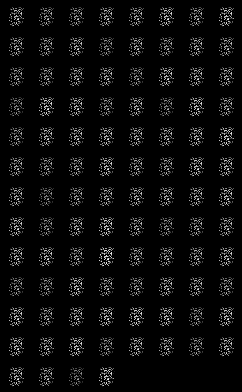
" alt="GAN Fake Image 1" />


<img src="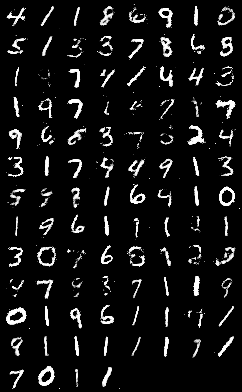
" alt="GAN Fake Image 100" />
